In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
import warnings
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [21]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
# Reading dataset as dataframe

df_img = pd.read_csv('./../data/cleaned/ferplus.csv')
df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,30,24,21,23,25,25,49,67,84,103,...,106,111,148,137,176,174,172,173,173,anger
1,123,125,124,142,209,226,234,236,231,232,...,103,116,111,105,105,103,97,91,89,anger
2,236,230,225,226,228,209,199,193,196,211,...,192,190,186,171,144,144,152,155,173,anger
3,255,82,0,3,0,0,0,0,0,0,...,101,217,255,198,143,236,254,254,254,anger
4,206,208,209,212,214,216,216,219,221,222,...,38,42,50,47,26,31,29,40,5,anger


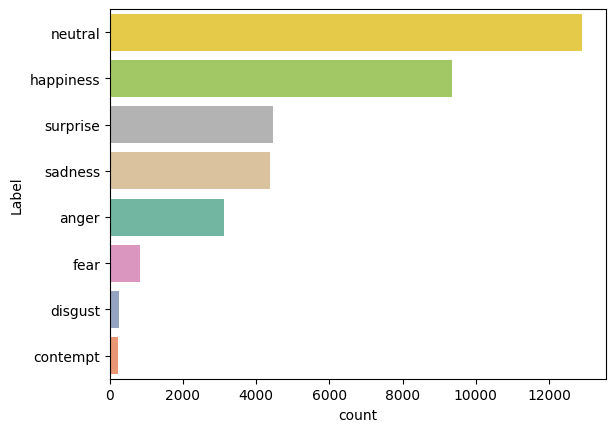

In [23]:
# Checking how many images we have for each label

counts = df_img['Label'].value_counts().sort_values(ascending=False)

sns.countplot(y=df_img['Label'], hue=df_img['Label'], order=counts.index, palette='Set2')
plt.show()

In [24]:
def normalize(value):
    return value/255

pixel_cols = [col for col in df_img.columns if 'Pixel' in col]

for col in pixel_cols:
    df_img[col].astype(float)

df_img.iloc[:, :-1] = df_img.iloc[:, :-1].apply(normalize)

df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,0.117647,0.094118,0.082353,0.090196,0.098039,0.098039,0.192157,0.262745,0.329412,0.403922,...,0.415686,0.435294,0.580392,0.537255,0.690196,0.682353,0.674510,0.678431,0.678431,anger
1,0.482353,0.490196,0.486275,0.556863,0.819608,0.886275,0.917647,0.925490,0.905882,0.909804,...,0.403922,0.454902,0.435294,0.411765,0.411765,0.403922,0.380392,0.356863,0.349020,anger
2,0.925490,0.901961,0.882353,0.886275,0.894118,0.819608,0.780392,0.756863,0.768627,0.827451,...,0.752941,0.745098,0.729412,0.670588,0.564706,0.564706,0.596078,0.607843,0.678431,anger
3,1.000000,0.321569,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.396078,0.850980,1.000000,0.776471,0.560784,0.925490,0.996078,0.996078,0.996078,anger
4,0.807843,0.815686,0.819608,0.831373,0.839216,0.847059,0.847059,0.858824,0.866667,0.870588,...,0.149020,0.164706,0.196078,0.184314,0.101961,0.121569,0.113725,0.156863,0.019608,anger


In [25]:
labels = df_img['Label'].unique().tolist()

mapping_dict = dict(zip(labels, range(8)))

df_img['Label'] = df_img['Label'].replace(mapping_dict)

df_img['Label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [26]:
# Splitting dataset into X and y

X = df_img.drop(columns='Label')
y = df_img['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

X_train_np = np.array(X_train).reshape((-1, 48, 48, 1))
y_train_np = np.array(y_train)
X_test_np = np.array(X_test).reshape((-1, 48, 48, 1))
y_test_np = np.array(y_test)

# Assuming y_train contains the class labels for your training data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights_dict = dict(enumerate(class_weights))

In [27]:
# Initializing model
model = Sequential()

# Conv layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening + dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 128)       

Epoch 1/20
710/710 - 3s - loss: 1.4293 - accuracy: 0.4730 - val_loss: 1.1799 - val_accuracy: 0.5770 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 2/20
710/710 - 3s - loss: 1.0729 - accuracy: 0.6220 - val_loss: 0.9912 - val_accuracy: 0.6409 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 3/20
710/710 - 3s - loss: 0.9130 - accuracy: 0.6742 - val_loss: 0.9256 - val_accuracy: 0.6684 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 4/20
710/710 - 3s - loss: 0.8142 - accuracy: 0.7103 - val_loss: 0.8967 - val_accuracy: 0.6798 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 5/20
710/710 - 3s - loss: 0.7333 - accuracy: 0.7393 - val_loss: 0.8321 - val_accuracy: 0.6990 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 6/20
710/710 - 3s - loss: 0.6565 - accuracy: 0.7644 - val_loss: 0.8540 - val_accuracy: 0.6960 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 7/20
710/710 - 3s - loss: 0.5858 - accuracy: 0.7903 - val_loss: 0.8292 - val_accuracy: 0.7122 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 8/20
710/710 - 3s - loss: 0.5194 - accuracy: 0.81

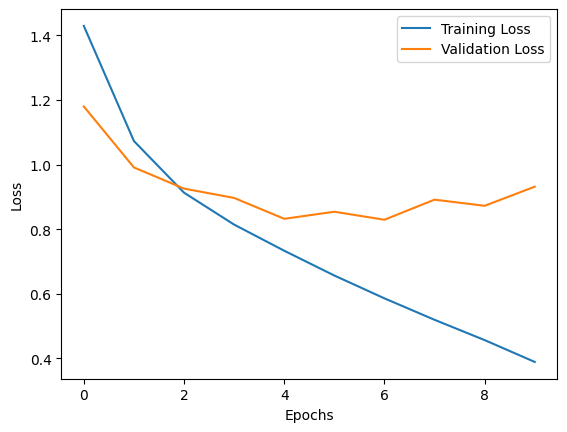

In [28]:
model_path = './../models/best_custom_model.h5'

callbacks = [EarlyStopping(patience=3, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=4, verbose=1),
             ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy')]

# Fitting

history = model.fit(X_train_np, y_train_np, epochs=20, batch_size=32, validation_split=0.2, verbose=2, callbacks=callbacks)

# Plotting train and val losses

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

222/222 [==============================] - 0s 2ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       618
           1       0.02      0.33      0.04         3
           2       0.32      0.50      0.39        32
           3       0.29      0.57      0.39        84
           4       0.78      0.84      0.81      1734
           5       0.74      0.73      0.74      2622
           6       0.56      0.45      0.50      1102
           7       0.78      0.77      0.78       902

    accuracy                           0.70      7097
   macro avg       0.51      0.60      0.53      7097
weighted avg       0.71      0.70      0.70      7097

Cohen-Kappa score: 0.6108440644305762


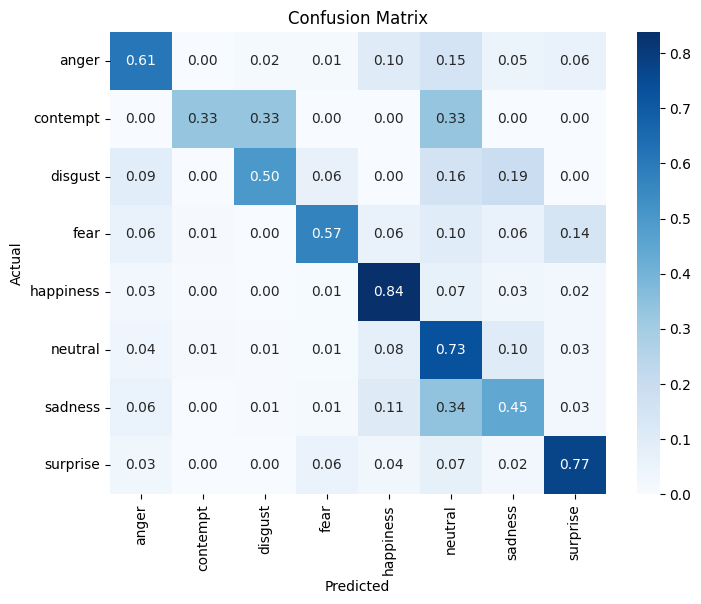

In [29]:
# Performance metrics on test set

y_pred_proba = model.predict(X_test_np)

y_pred = [np.argmax(x) for x in y_pred_proba]

cr = classification_report(y_pred, y_test)
print(f'Classification report:\n{cr}')

chs = cohen_kappa_score(y_pred, y_test)
print(f'Cohen-Kappa score: {chs}')

cm = confusion_matrix(y_pred, y_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()